<a href="https://colab.research.google.com/github/Kimtaewookdev/Sec1_project/blob/main/AI_13_%EA%B9%80%ED%83%9C%EC%9A%B1_Section1_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Section 1 Project 다음 분기 게임 설계


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

### 데이터 전처리

In [2]:
data_url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv'
data = pd.read_csv(data_url, index_col=0)

df = pd.DataFrame(data)
df.info()
# 'Year', 'Genre', 'Publisher'에 결측치 확인

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.3+ MB


In [3]:
# 연도 특성의 00 년 단위 데이터 조정
for i in range(1, len(df)+1):
  if df.at[i,'Year'] <= 50:
    df.at[i,'Year'] += 2000
  elif 50 < df.at[i,'Year'] <= 100:
    df.at[i,'Year'] += 1900

In [4]:
# 퍼블리셔 특성의 'Unknown'을 결측치로 취급
df['Publisher'] = df['Publisher'].replace('Unknown', np.NAN)

In [5]:
# 장르 특성의 'Misc'을 결측치로 취급
df['Genre'] = df['Genre'].replace('Misc', np.NAN)

In [6]:
# 출고량 단위는 표기되어있지않으나 M(백만 장)으로 추측
# 출고량 데이터 중 단위 M이 남아있거나 K(천 장)이 표기된 것 있음
# M은 제거하고 K는 0.001을 곱해 M으로 환산

for col in df.columns[-4:]:
  df[col] = df[col].replace({"K":"*1e-3", "M":""}, regex=True).apply(pd.eval)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        14814 non-null  object 
 4   Publisher    16337 non-null  object 
 5   NA_Sales     16598 non-null  float64
 6   EU_Sales     16598 non-null  float64
 7   JP_Sales     16598 non-null  float64
 8   Other_Sales  16598 non-null  float64
dtypes: float64(5), object(4)
memory usage: 1.8+ MB


In [9]:
# 전세계 출고량 특성 추가
df['Total_Sales'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']

In [12]:
# 연도 제한 1996년 이전, 2016년 이전은 표본의 수가 적어 임의로 제거
df = df[(df['Year'] >= 1997) & (df['Year'] <= 2016)]

In [15]:
# 결측치 제거
df.dropna(inplace = True)

In [16]:
# 분석 전 Total_Sales 분포 형태
print(f'왜도 = {(df["Total_Sales"]).skew()}')
print(f'첨도 = {(df["Total_Sales"]).kurt()}')

왜도 = 19.587835486010334
첨도 = 795.3738891080023


###  지역에 따라서 선호하는 게임 장르 분석

- 지역의 장르별 출고량 비중
- 지역의 장르별 평균 출고량 비중

In [18]:
sales = df.columns[-5:-1]
col_g = sales.insert(0, 'Genre')

def get_top(df, n=3):
  top = dict()
  for col in df.columns:
    top[col] = dict(df[col].sort_values(ascending=False).head(n)).items()
  return pd.DataFrame(top).T

# 각 지역의 장르별 출고량 상위
df_g_sum = df[col_g].groupby('Genre').sum().round(3)

print(f'pvalue = {stats.chi2_contingency(df_g_sum * 1e+6)[1]}')

get_top(df_g_sum)

pvalue = 0.0


,0,1,2
NA_Sales,"(Action, 796.32)","(Sports, 640.36)","(Shooter, 513.05)"
EU_Sales,"(Action, 499.09)","(Sports, 361.89)","(Shooter, 301.29)"
JP_Sales,"(Role-Playing, 271.46)","(Action, 138.05)","(Sports, 95.19)"
Other_Sales,"(Action, 181.26)","(Sports, 130.56)","(Shooter, 100.09)"


In [19]:
# 각 지역의 장르별 평균 출고량 상위
df_g_mean = df[col_g].groupby('Genre').mean().round(3)

print(f'pvalue = {stats.chi2_contingency(df_g_mean * 1e+6)[1]}')

get_top(df_g_mean)

pvalue = 0.0


,0,1,2
NA_Sales,"(Shooter, 0.436)","(Platform, 0.388)","(Sports, 0.299)"
EU_Sales,"(Shooter, 0.256)","(Platform, 0.209)","(Racing, 0.192)"
JP_Sales,"(Role-Playing, 0.201)","(Platform, 0.083)","(Fighting, 0.074)"
Other_Sales,"(Shooter, 0.085)","(Racing, 0.064)","(Sports, 0.061)"


In [20]:
# 각 지역의 장르별 출고량 중앙값 상위
df_g_median = df[col_g].groupby('Genre').median().round(3)

print(f'pvalue = {stats.chi2_contingency(df_g_median * 1e+6)[1]}')

get_top(df_g_median)

pvalue = 0.0


,0,1,2
NA_Sales,"(Platform, 0.13)","(Shooter, 0.13)","(Sports, 0.115)"
EU_Sales,"(Shooter, 0.06)","(Platform, 0.05)","(Racing, 0.04)"
JP_Sales,"(Role-Playing, 0.05)","(Adventure, 0.01)","(Fighting, 0.01)"
Other_Sales,"(Shooter, 0.02)","(Action, 0.01)","(Fighting, 0.01)"


### 연도별 게임의 트렌드 분석

- 연도마다 게임 수가 많은 장르 
- 연도마다 Total sales 합계가 가장 높은 장르
- 연도마다 Total sales 평균이 가장 높은 장르

1997년부터 2016년까지의 데이터를 고려, 그외 연도는 표본 개수가 현저히 적기에 제외

In [21]:
# 연도별 게임 발매수가 많은 장르
genre_n_py = pd.crosstab(df['Year'], df['Genre'])

print(f'pvalue = {stats.chi2_contingency(genre_n_py)[1]}')

get_top(genre_n_py.T)

pvalue = 4.3808509437076028e-249


,0,1,2
1997.0,"(Sports, 46)","(Racing, 36)","(Action, 31)"
1998.0,"(Sports, 70)","(Racing, 48)","(Action, 44)"
1999.0,"(Sports, 62)","(Racing, 49)","(Action, 39)"
2000.0,"(Sports, 81)","(Action, 43)","(Racing, 43)"
2001.0,"(Sports, 96)","(Racing, 70)","(Action, 66)"
2002.0,"(Sports, 187)","(Action, 125)","(Racing, 103)"
2003.0,"(Action, 143)","(Sports, 125)","(Racing, 109)"
2004.0,"(Action, 125)","(Sports, 103)","(Shooter, 88)"
2005.0,"(Action, 192)","(Sports, 121)","(Shooter, 96)"
2006.0,"(Action, 184)","(Sports, 138)","(Role-Playing, 107)"


In [22]:
# 연도별 전세계 출고량 합계가 가장 높은 장르
genre_sum_py = pd.pivot_table(df,
                              values='Total_Sales',
                              index=['Year'],
                              columns=['Genre'],
                              aggfunc=np.sum, 
                              fill_value=0).round(3)

print(f'pvalue = {stats.chi2_contingency(genre_sum_py * 1e+6)[1]}')

get_top(genre_sum_py.T)

pvalue = 0.0


,0,1,2
1997.0,"(Racing, 31.92)","(Sports, 30.04)","(Action, 27.59)"
1998.0,"(Sports, 41.75)","(Action, 39.41)","(Fighting, 31.68)"
1999.0,"(Role-Playing, 47.24)","(Racing, 37.19)","(Sports, 30.21)"
2000.0,"(Sports, 41.24)","(Action, 33.89)","(Role-Playing, 29.04)"
2001.0,"(Action, 56.68)","(Racing, 53.98)","(Sports, 51.47)"
2002.0,"(Action, 86.65)","(Sports, 65.29)","(Shooter, 47.64)"
2003.0,"(Action, 67.04)","(Sports, 55.96)","(Racing, 52.18)"
2004.0,"(Action, 76.15)","(Sports, 61.11)","(Role-Playing, 53.95)"
2005.0,"(Action, 85.52)","(Sports, 58.64)","(Racing, 56.4)"
2006.0,"(Sports, 136.12)","(Action, 66.49)","(Role-Playing, 51.69)"


In [23]:
# 연도별 게임의 전세계 출고량 평균이 가장 높은 장르
genre_mean_py = pd.pivot_table(df,
                               values='Total_Sales',
                               index=['Year'],
                               columns=['Genre'],
                               aggfunc=np.mean,
                               fill_value=0).round(3)

print(f'pvalue = {stats.chi2_contingency(genre_mean_py * 1e+6)[1]}')

get_top(genre_mean_py.T)

pvalue = 0.0


,0,1,2
1997.0,"(Platform, 1.214)","(Role-Playing, 0.949)","(Action, 0.89)"
1998.0,"(Platform, 1.193)","(Role-Playing, 1.08)","(Action, 0.896)"
1999.0,"(Role-Playing, 1.476)","(Platform, 1.156)","(Shooter, 0.764)"
2000.0,"(Role-Playing, 1.001)","(Action, 0.788)","(Fighting, 0.699)"
2001.0,"(Fighting, 1.006)","(Platform, 0.933)","(Action, 0.859)"
2002.0,"(Role-Playing, 0.835)","(Action, 0.693)","(Shooter, 0.611)"
2003.0,"(Role-Playing, 0.631)","(Simulation, 0.606)","(Fighting, 0.541)"
2004.0,"(Role-Playing, 0.899)","(Platform, 0.717)","(Racing, 0.652)"
2005.0,"(Simulation, 1.297)","(Racing, 0.732)","(Puzzle, 0.633)"
2006.0,"(Sports, 0.986)","(Platform, 0.92)","(Shooter, 0.556)"


In [24]:
# 연도별 게임의 전세계 출고량 중앙값이 가장 높은 장르
genre_median_py = pd.pivot_table(df,
                                values='Total_Sales',
                                index=['Year'],
                                columns=['Genre'],
                                aggfunc=np.median,
                                fill_value=0).round(3)

print(f'pvalue = {stats.chi2_contingency(genre_median_py * 1e+6)[1]}')

get_top(genre_median_py.T)

pvalue = 0.0


,0,1,2
1997.0,"(Sports, 0.49)","(Role-Playing, 0.4)","(Simulation, 0.32)"
1998.0,"(Simulation, 0.825)","(Platform, 0.46)","(Sports, 0.45)"
1999.0,"(Platform, 0.465)","(Role-Playing, 0.435)","(Action, 0.4)"
2000.0,"(Role-Playing, 0.36)","(Action, 0.34)","(Platform, 0.285)"
2001.0,"(Fighting, 0.47)","(Simulation, 0.315)","(Platform, 0.285)"
2002.0,"(Platform, 0.25)","(Shooter, 0.215)","(Action, 0.21)"
2003.0,"(Simulation, 0.35)","(Fighting, 0.28)","(Sports, 0.26)"
2004.0,"(Platform, 0.35)","(Sports, 0.28)","(Simulation, 0.27)"
2005.0,"(Fighting, 0.26)","(Simulation, 0.245)","(Sports, 0.22)"
2006.0,"(Role-Playing, 0.18)","(Sports, 0.17)","(Fighting, 0.16)"


### 출고량 높은 게임에 대한 분석 및 시각화 프로세스

전체 출고량 상위 5% 게임을 장르, 플랫폼, 퍼블리셔에 대해 분석, 시각화

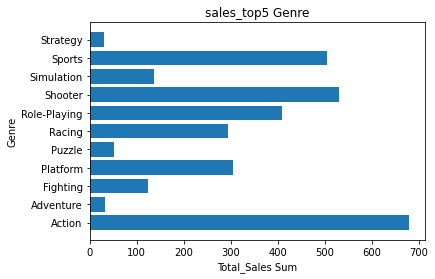

In [25]:
# 출고량 내림차순 정렬
sales = df.sort_values(by = 'Total_Sales', ascending = False, ignore_index = True)

# 상위 5%
sales_top5 = sales[:int(len(sales) * 0.05)]

def get_df_name(df):
  name = [x for x in globals() if globals()[x] is df][0]
  return name

def get_bar_sum(df, col):
  a = df.groupby([col]).Total_Sales.sum()
  plt.barh(a.index, a)
  plt.title(get_df_name(df) + ' ' + col)
  plt.xlabel('Total_Sales Sum')
  plt.ylabel(col)
  plt.show()

def get_bar_mean(df, col):
  a = df.groupby([col]).Total_Sales.mean()
  plt.barh(a.index, a)
  plt.title(get_df_name(df) + ' ' + col)
  plt.xlabel('Total_Sales Mean')
  plt.ylabel(col)
  plt.show()

def get_bar_median(df, col):
  a = df.groupby([col]).Total_Sales.median()
  plt.barh(a.index, a)
  plt.title(get_df_name(df) + ' ' + col)
  plt.xlabel('Total_Sales Median')
  plt.ylabel(col)
  plt.show()

get_bar_sum(sales_top5, 'Genre')

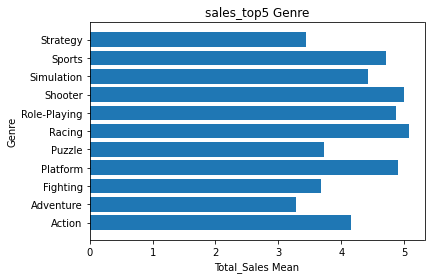

In [19]:
get_bar_mean(sales_top5, 'Genre')

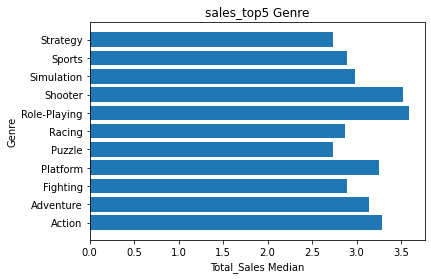

In [20]:
get_bar_median(sales_top5, 'Genre')

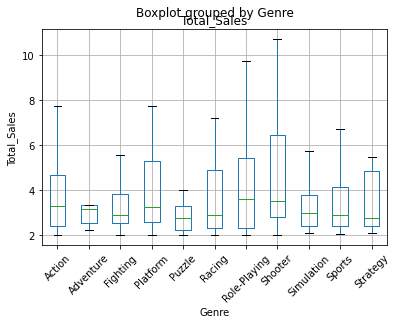

In [26]:
sales_top5.boxplot(column='Total_Sales', by='Genre', rot=45, showfliers=False)
plt.ylabel('Total_Sales')
plt.show()

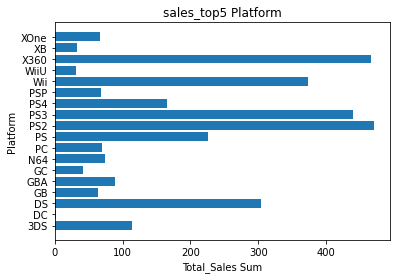

In [22]:
# 플랫폼은 많은 이용자가 있어야므로 합계 지표를 봐야한다고 생각
get_bar_sum(sales_top5, 'Platform')

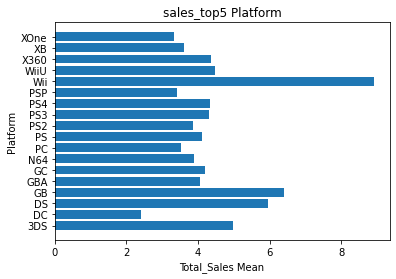

In [28]:
# 근거 평균의 경우 게임보이가 두 번째로 높은 플랫폼이다.
get_bar_mean(sales_top5, 'Platform')

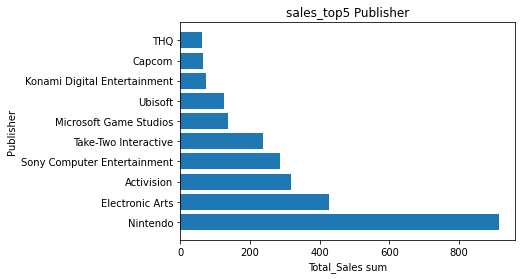

In [85]:
# Publisher 특성의 sum, mean, median 시각화

def get_bar_pub(df, fun='sum'):
  a = df.groupby(['Publisher']).Total_Sales.sum()
  if fun == 'mean':
    a = df.groupby(['Publisher']).Total_Sales.mean()
  elif fun == 'median':
    a = df.groupby(['Publisher']).Total_Sales.median()
  b = a.sort_values(ascending = False)[:10]
  plt.barh(b.index, b)
  plt.title(get_df_name(df) + ' ' + 'Publisher')
  plt.xlabel('Total_Sales ' + fun)
  plt.ylabel('Publisher')
  plt.show()

get_bar_pub(sales_top5)

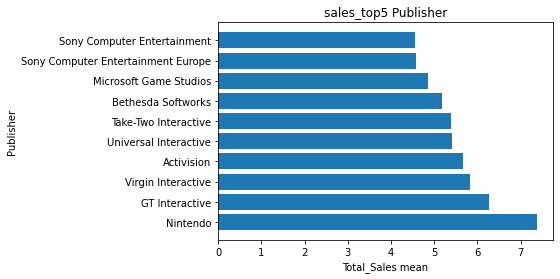

In [86]:
get_bar_pub(sales_top5, 'mean')

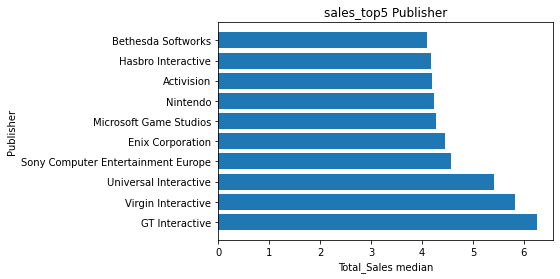

In [87]:
get_bar_pub(sales_top5, 'median')

### 2012 - 2016년까지의 게임 분석

다음 분기의 게임을 설계하는데 십수년전 데이터를 고려하는 것은 적실성이 떨어진다.   
분석할 수 있는 가장 최신의 5개년 데이터만을 다룬다.

In [46]:
sales_1216 = df[(2012<= df['Year']) & (df['Year'] <= 2016)]

def describe(df, col):
  return df.groupby([col]).Total_Sales.describe()

print(f'왜도 = {(sales_1216["Total_Sales"]).skew()}')
print(f'첨도 = {(sales_1216["Total_Sales"]).kurt()}')

왜도 = 7.099334891507426
첨도 = 73.64357382491143


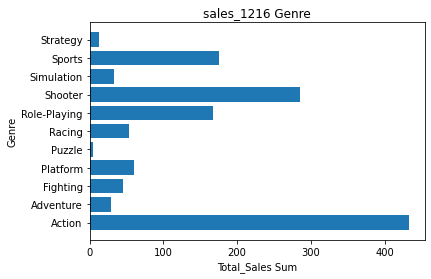

In [37]:
get_bar_sum(sales_1216, 'Genre')

In [50]:
get_top(describe(sales_1216, 'Genre').round(3))

,0,1,2
count,"(Action, 958.0)","(Role-Playing, 355.0)","(Adventure, 274.0)"
mean,"(Shooter, 1.299)","(Platform, 0.739)","(Sports, 0.673)"
std,"(Shooter, 2.278)","(Platform, 1.375)","(Simulation, 1.31)"
min,"(Action, 0.01)","(Adventure, 0.01)","(Fighting, 0.01)"
25%,"(Shooter, 0.13)","(Platform, 0.07)","(Sports, 0.07)"
50%,"(Shooter, 0.45)","(Platform, 0.245)","(Sports, 0.235)"
75%,"(Shooter, 1.44)","(Platform, 0.855)","(Sports, 0.782)"
max,"(Action, 21.39)","(Shooter, 14.24)","(Role-Playing, 11.33)"


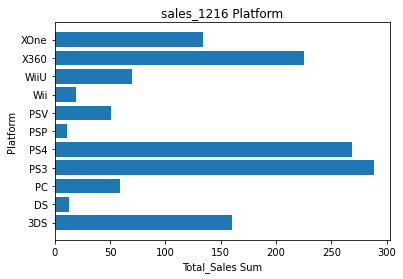

In [52]:
get_bar_sum(sales_1216, 'Platform')

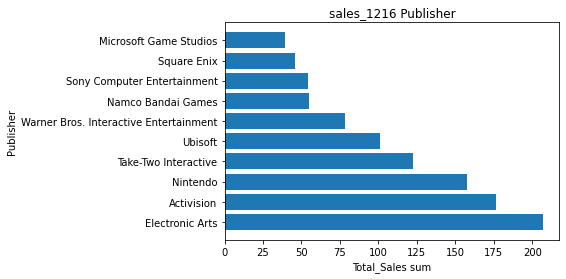

In [88]:
get_bar_pub(sales_1216, 'sum')

In [91]:
get_top(describe(sales_1216, 'Publisher').round(3))

,0,1,2
count,"(Namco Bandai Games, 299.0)","(Electronic Arts, 176.0)","(Activision, 167.0)"
mean,"(Nintendo, 1.625)","(Hello Games, 1.6)","(Microsoft Game Studios, 1.517)"
std,"(Take-Two Interactive, 3.1)","(Activision, 2.378)","(Nintendo, 2.267)"
min,"(Hello Games, 1.6)","(mixi, Inc, 0.86)","(Activision Blizzard, 0.48)"
25%,"(Hello Games, 1.6)","(mixi, Inc, 0.86)","(NCSoft, 0.702)"
50%,"(Hello Games, 1.6)","(NCSoft, 1.235)","(Microsoft Game Studios, 0.975)"
75%,"(Nintendo, 1.83)","(Microsoft Game Studios, 1.78)","(NCSoft, 1.767)"
max,"(Take-Two Interactive, 21.39)","(Activision, 14.24)","(Nintendo, 11.33)"


다음 분기 게임 설계

지역에 따라서 선호하는 게임 장르가 다를까 라는 질문에 대답을 하셔야합니다.

연도별 게임의 트렌드가 있을까 라는 질문에 대답을 하셔야합니다.

출고량이 높은 게임에 대한 분석 및 시각화 프로세스가 포함되어야 합니다.

개인적인 분석 목표, 질문

- 플랫폼 장르에는 마리오 시리즈, 롤플레잉에는 포켓몬 시리즈같은 대형 ip가 있어 크게 잡히는 것일 수 있다. 따라서 장르와 퍼블리셔와 플랫폼에 대한 분석이 필요하다.